## Connect to AML workspace & access data

In [1]:
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()

In [2]:
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

csamlfsi-ws
csamlfsi-rg
eastus2
43ab27bb-ee6c-4f68-b9cf-a26c4c454a4a


In [3]:
dataset = Dataset.get_by_name(ws, name='ntnu-testimon_paysim1')
df = dataset.to_pandas_dataframe()

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df = df.sample(1000*1000)

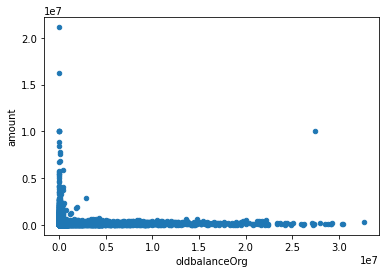

In [6]:
import matplotlib.pyplot as plt
df.sample(10000).plot(kind='scatter', x='oldbalanceOrg', y='amount')
plt.show()

## Train model

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

df.drop("step", axis=1, inplace=True)
df.drop("isFlaggedFraud", axis=1, inplace=True)

# Dropping for demo reasons
df.drop("nameOrig", axis=1, inplace=True)
df.drop("nameDest", axis=1, inplace=True)

y_raw = df['isFraud']
X_raw = df.drop('isFraud', axis=1)

categorical_features = X_raw.select_dtypes(include=['object']).columns
numeric_features = X_raw.select_dtypes(include=['int64', 'float']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
    ('onehotencoder', OneHotEncoder(categories='auto', sparse=False))])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

feature_engineering_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder="drop")

# Encode Labels
le = LabelEncoder()
encoded_y = le.fit_transform(y_raw)

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, encoded_y, test_size=0.20, stratify=encoded_y, random_state=42)

# Create sklearn pipeline
lr_clf = Pipeline(steps=[('preprocessor', feature_engineering_pipeline),
                         ('classifier', LogisticRegression(solver="saga", max_iter=100))])

In [9]:
from azureml.core import Experiment

experiment_name = 'aml_fraud_local'
experiment = Experiment(ws, experiment_name)

run = experiment.start_logging()

# Train the model
lr_clf.fit(X_train, y_train)

# Capture metrics
train_acc = lr_clf.score(X_train, y_train)
test_acc = lr_clf.score(X_test, y_test)
print("Training accuracy: %.3f" % train_acc)
print("Test data accuracy: %.3f" % test_acc)

# Log to Azure ML
run.log('Train accuracy', train_acc)
run.log('Test accuracy', test_acc)
    
run.complete()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Training accuracy: 0.999
Test data accuracy: 0.999


In [ ]:
from sklearn.externals import joblib

joblib.dump(value=lr_clf, filename='model.pkl')

# Upload our model to our experiment
run.upload_file(name = 'outputs/model.pkl', path_or_stream = './model.pkl')

In [ ]:
model = run.register_model(model_name='aml-fraud-model',
                           model_path='outputs/model.pkl',
                           datasets=[['training-dataset', dataset]],
                           tags={"source": "local_training_demo"})

## Calculate Model Explaination

In [ ]:
# Explain model
from azureml.core.run import Run
from azureml.interpret import ExplanationClient
from interpret.ext.blackbox import TabularExplainer

client = ExplanationClient.from_run(run)

explainer = TabularExplainer(lr_clf.steps[-1][1], 
                             initialization_examples=X_train, 
                             features=X_raw.columns, 
                             classes=["NotFraud", "Fraud"], 
                             transformations=feature_engineering_pipeline)

# explain overall model predictions (global explanation)
global_explanation = explainer.explain_global(X_test)

# Sorted SHAP values
print('ranked global importance values: {}'.format(global_explanation.get_ranked_global_values()))
# Corresponding feature names
print('ranked global importance names: {}'.format(global_explanation.get_ranked_global_names()))
# Feature ranks (based on original order of features)
print('global importance rank: {}'.format(global_explanation.global_importance_rank))

client = ExplanationClient.from_run(run)
client.upload_model_explanation(global_explanation, comment='Global Explanation: All Features')
